### **Проект. Прогнозирование ухода абонентов от оператора связи.**

### **Цель проекта.**                                 
Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах. Цель: обучение модели прогнозированию ухода клиента от оператора связи.

### **Описание данных.**
Оператор предоставляет два основных типа услуг: 

- 1.	Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
    <br>
- 2.	Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).
    <br>
  Также доступны такие услуги:
    <br>
•	Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
    <br>
•	Выделенная линия технической поддержки (TechSupport);
    <br>
•	Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
    <br>
•	Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).
    <br>
За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### **План работы.**
1. Исследовательский анализ данных.
2. Предобработка данных датасетов. Обучение модели задачи классификации. Проверка успешности модели.
3. Подготовка данных к обучению.
4. Обучение.
5. Тестирование.
6. Вывод.

### **Вывод**
Лучшей моделью обчения стала модель CatBoostClassifier. Она показала высокий результат по метрике roc_auc = 0.92.r   Тестирование лучшей модели подтвердило успешность обучения, roc_auc = 0.<     По результатам предсказания матрица ошибок тестовой выборки показывает, что модель обучения CatBoostClassifier успешна в предсказании того, что клиент останется = (практически безошибочно) 0.95, при этом уровень предсказания ухода клиента менее успешен = 0.>
    Результат обучения говорит о том, что модель нужно дообучать на большем количестве данных. Возможно нужны дополнительные признаки, которые характеризуют факт ухода клСамые важные признаки,    <br> влияющие на уход клиента: Period, MonthlyCharges и Type и InternetSЦель проекта выполнена датасет обучен прогнозировать факт ухода абонентов. Обозначены дальнейшие действия по улучшению модели.выполнены.

##### **1. Исследовательский анализ данных.**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings

from numpy.random import RandomState
from tqdm import notebook
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoost, CatBoostClassifier, Pool
import re
from sklearn.metrics import plot_confusion_matrix
from matplotlib import cm
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
warnings.filterwarnings('ignore')

RANDOM_STATE = 180723

In [2]:
contract_data = pd.read_csv('/d/contract.csv',
                            index_col=['customerID'],parse_dates=['BeginDate', 'EndDate'])

personal_data = pd.read_csv('/d/personal.csv', index_col='customerID')

internet_data = pd.read_csv('/d/internet.csv', index_col='customerID')

phone_data = pd.read_csv('/d/phone.csv', index_col='customerID')

In [3]:
contract_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 440.2+ KB


In [4]:
contract_data.head(10)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05


In [5]:
contract_data.shape

(7043, 7)

In [6]:
contract_data.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [7]:
contract_data.isnull().sum()

BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

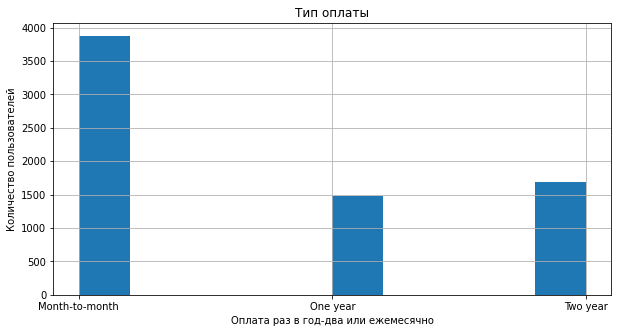

In [8]:
contract_data['Type'].hist(figsize=(10, 5))
plt.title('Тип оплаты')
plt.xlabel('Оплата раз в год-два или ежемесячно')
plt.ylabel('Количество пользователей');

In [9]:
contract_data.pivot_table(index='Type', values='MonthlyCharges')

,MonthlyCharges
Type,
Month-to-month,66.398490
One year,65.048608
Two year,60.770413


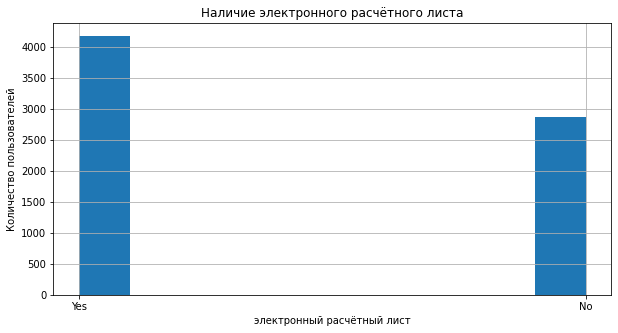

In [10]:
contract_data['PaperlessBilling'].hist(figsize=(10, 5))
plt.title('Наличие электронного расчётного листа')
plt.xlabel('электронный расчётный лист')
plt.ylabel('Количество пользователей');

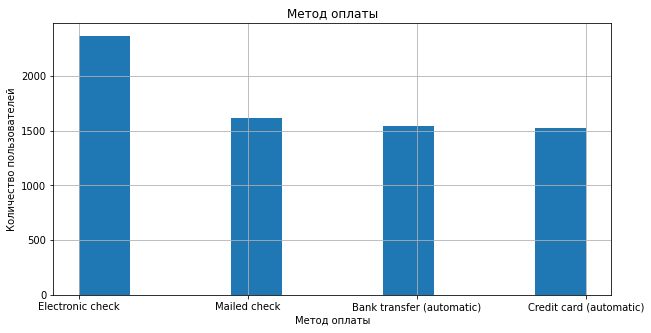

In [11]:
contract_data['PaymentMethod'].hist(figsize=(10, 5))
plt.title('Метод оплаты')
plt.xlabel('Метод оплаты')
plt.ylabel('Количество пользователей');

In [12]:
contract_data.pivot_table(index='PaymentMethod', values='MonthlyCharges')

,MonthlyCharges
PaymentMethod,
Bank transfer (automatic),67.192649
Credit card (automatic),66.512385
Electronic check,76.255814
Mailed check,43.917060


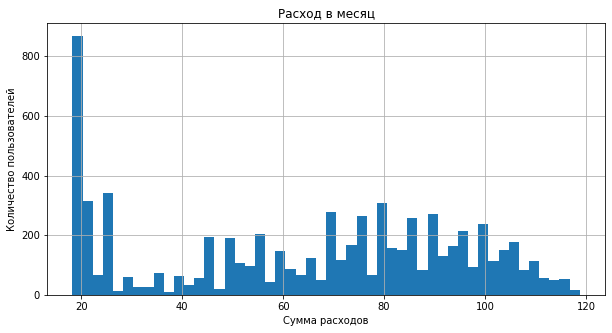

In [13]:
contract_data['MonthlyCharges'].hist(bins=50, figsize=(10, 5))
plt.title('Расход в месяц')
plt.xlabel('Сумма расходов')
plt.ylabel('Количество пользователей');

In [14]:
personal_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


In [15]:
personal_data.head(10)

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No
9305-CDSKC,Female,0,No,No
1452-KIOVK,Male,0,No,Yes
6713-OKOMC,Female,0,No,No
7892-POOKP,Female,0,Yes,No


In [16]:
personal_data.shape

(7043, 4)

In [17]:
personal_data.isnull().sum()

gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

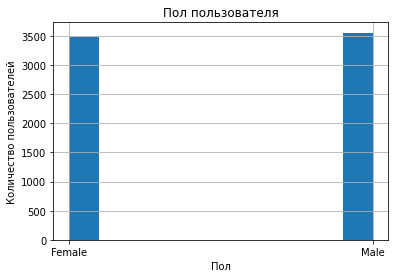

In [18]:
personal_data['gender'].hist()
plt.title('Пол пользователя')
plt.xlabel('Пол')
plt.ylabel('Количество пользователей');

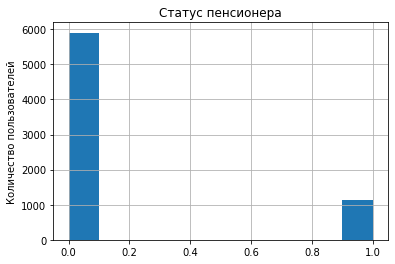

In [19]:
personal_data['SeniorCitizen'].hist()
plt.title('Статус пенсионера')
plt.ylabel('Количество пользователей');

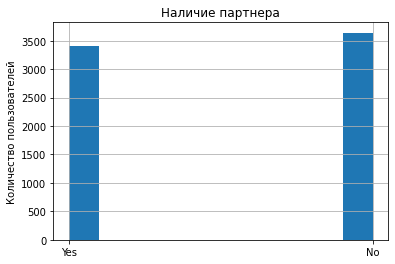

In [20]:
personal_data['Partner'].hist()
plt.title('Наличие партнера')
plt.ylabel('Количество пользователей');

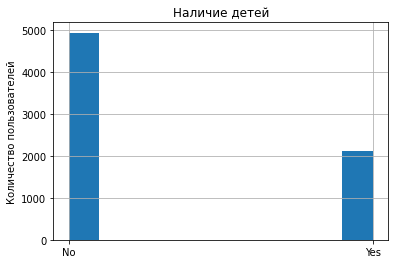

In [21]:
personal_data['Dependents'].hist()
plt.title('Наличие детей')
plt.ylabel('Количество пользователей');

In [22]:
internet_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


In [23]:
internet_data.head(10)

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No
9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
6713-OKOMC,DSL,Yes,No,No,No,No,No
7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes


In [24]:
internet_data.shape

(5517, 7)

In [25]:
internet_data.describe()

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517
unique,2,2,2,2,2,2,2
top,Fiber optic,No,No,No,No,No,No
freq,3096,3498,3088,3095,3473,2810,2785


In [26]:
internet_data.isnull().sum()

InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

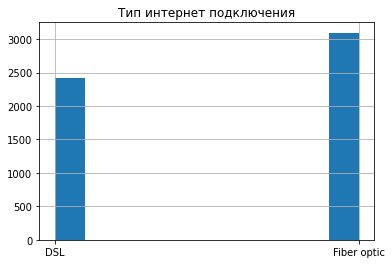

In [27]:
internet_data['InternetService'].hist()
plt.title('Тип интернет подключения');

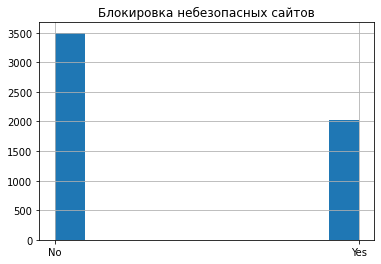

In [28]:
internet_data['OnlineSecurity'].hist()
plt.title('Блокировка небезопасных сайтов');

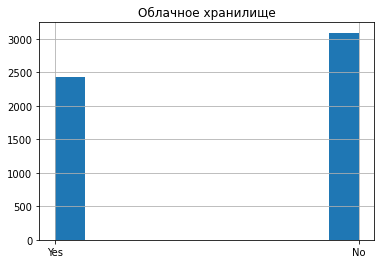

In [29]:
internet_data['OnlineBackup'].hist()
plt.title('Облачное хранилище');

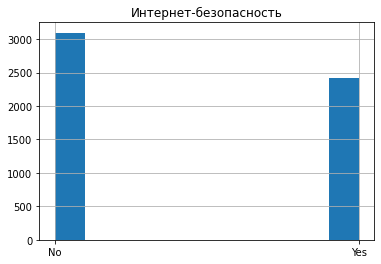

In [30]:
internet_data['DeviceProtection'].hist()
plt.title('Интернет-безопасность');

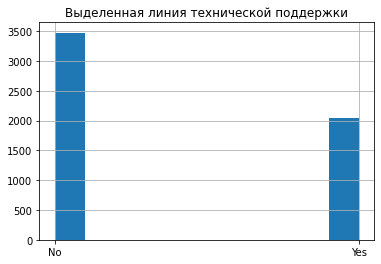

In [31]:
internet_data['TechSupport'].hist()
plt.title('Выделенная линия технической поддержки');

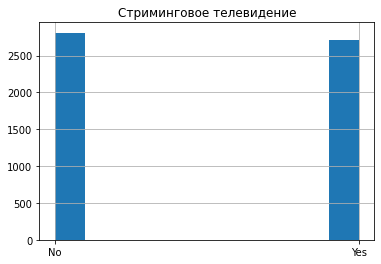

In [32]:
internet_data['StreamingTV'].hist()
plt.title('Стриминговое телевидение');

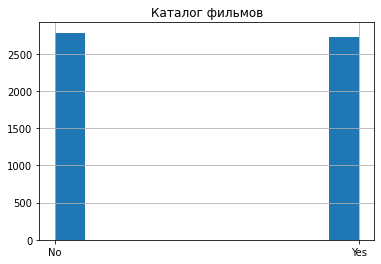

In [33]:
internet_data['StreamingMovies'].hist()
plt.title('Каталог фильмов');

In [34]:
phone_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


In [35]:
phone_data.head(3)

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No


In [36]:
phone_data.shape

(6361, 1)

In [37]:
phone_data.describe()

,MultipleLines
count,6361
unique,2
top,No
freq,3390


In [38]:
phone_data.isnull().sum()

MultipleLines    0
dtype: int64

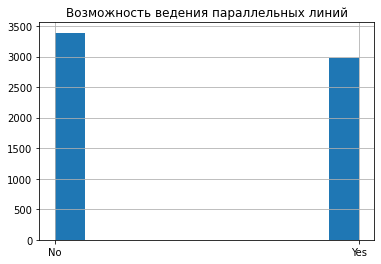

In [39]:
phone_data['MultipleLines'].hist()
plt.title('Возможность ведения параллельных линий');

##### **2. Предобработка данных датасетов. Обучение модели задачи классификации. Проверка успешности модели.**

In [40]:
data_contract = contract_data.copy()

In [41]:
data_contract['Churn'] = (data_contract['EndDate'] != 'No').astype(int)

In [42]:
data_contract.loc[data_contract['TotalCharges'] == " ", 'TotalCharges'] = 0

In [43]:
data_contract['TotalCharges'] = data_contract['TotalCharges'].astype(float)

In [44]:
data_contract['BeginDate'] = pd.to_datetime(data_contract['BeginDate'])

data_contract['MonthlyCharges'] = data_contract['MonthlyCharges'].astype('float')

In [45]:
data_contract['EndDate'] = data_contract['EndDate'].where(data_contract['EndDate'] != 'No', '2020-02-01')

data_contract['EndDate'] = pd.to_datetime(data_contract['EndDate'])

In [46]:
data_contract['Period'] = (data_contract['EndDate'] - data_contract['BeginDate']).dt.days

In [47]:
data_contract.head(5)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Period
customerID,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1036
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61


In [48]:
personal_data.drop(['SeniorCitizen'], axis= 1, inplace=True)

In [49]:
data_contract.drop(['PaperlessBilling'], axis= 1, inplace=True)

In [50]:
data_contract.drop(['PaymentMethod'], axis= 1, inplace=True)

In [51]:
data_contract.drop(['BeginDate', 'EndDate'], axis= 1, inplace=True)

In [52]:
data = data_contract.join(personal_data)

In [53]:
data = data.join(internet_data)

In [54]:
data = data.join(phone_data)

In [55]:
data.head(5)

,Type,MonthlyCharges,TotalCharges,Churn,Period,gender,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,29.85,29.85,0,31,Female,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,One year,56.95,1889.50,0,1036,Male,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,Month-to-month,53.85,108.15,1,61,Male,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,One year,42.30,1840.75,0,1371,Male,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,Month-to-month,70.70,151.65,1,61,Female,No,No,Fiber optic,No,No,No,No,No,No,No


In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   MonthlyCharges    7043 non-null   float64
 2   TotalCharges      7043 non-null   float64
 3   Churn             7043 non-null   int64  
 4   Period            7043 non-null   int64  
 5   gender            7043 non-null   object 
 6   Partner           7043 non-null   object 
 7   Dependents        7043 non-null   object 
 8   InternetService   5517 non-null   object 
 9   OnlineSecurity    5517 non-null   object 
 10  OnlineBackup      5517 non-null   object 
 11  DeviceProtection  5517 non-null   object 
 12  TechSupport       5517 non-null   object 
 13  StreamingTV       5517 non-null   object 
 14  StreamingMovies   5517 non-null   object 
 15  MultipleLines     6361 non-null   object 
dtypes: float64(2), int64(2), object(

In [57]:
print('Размер выборки:', data.shape)
print('Количество явных дубликатов:', data.duplicated().sum())
print('Количество пропущенных значений:', data.isna().sum())

Размер выборки: (7043, 16)
Количество явных дубликатов: 49
Количество пропущенных значений: Type                   0
MonthlyCharges         0
TotalCharges           0
Churn                  0
Period                 0
gender                 0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64


In [58]:
data = data.fillna('No')


In [59]:
print('Количество пропущенных значений:', data.isna().sum())

Количество пропущенных значений: Type                0
MonthlyCharges      0
TotalCharges        0
Churn               0
Period              0
gender              0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64


In [60]:
data.describe()

,MonthlyCharges,TotalCharges,Churn,Period
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.734304,0.265370,985.996166
std,30.090047,2266.794470,0.441561,747.587844
min,18.250000,0.000000,0.000000,0.000000
25%,35.500000,398.550000,0.000000,273.000000
50%,70.350000,1394.550000,0.000000,883.000000
75%,89.850000,3786.600000,1.000000,1676.000000
max,118.750000,8684.800000,1.000000,2191.000000


In [61]:
data = data.drop_duplicates()

In [62]:
print('Количество явных дубликатов:', data.duplicated().sum())

Количество явных дубликатов: 0


In [63]:
data.head(3)

,Type,MonthlyCharges,TotalCharges,Churn,Period,gender,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,29.85,29.85,0,31,Female,Yes,No,DSL,No,Yes,No,No,No,No,No
5575-GNVDE,One year,56.95,1889.50,0,1036,Male,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,Month-to-month,53.85,108.15,1,61,Male,No,No,DSL,Yes,Yes,No,No,No,No,No


In [64]:
print(data.corr())

                MonthlyCharges  TotalCharges     Churn    Period
MonthlyCharges        1.000000      0.649332  0.194221  0.240287
TotalCharges          0.649332      1.000000 -0.198302  0.824790
Churn                 0.194221     -0.198302  1.000000 -0.354164
Period                0.240287      0.824790 -0.354164  1.000000


AxesSubplot(0.125,0.125;0.62x0.755)


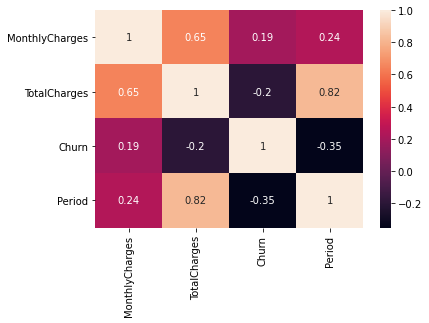

In [65]:
print(sns.heatmap(data.corr(), annot=True));

In [66]:
data.drop(['TotalCharges'], axis= 1, inplace=True)

In [67]:
data.groupby('gender')['Churn'].sum()

gender
Female    928
Male      923
Name: Churn, dtype: int64

In [68]:
data.drop(['gender'], axis= 1, inplace=True)

In [69]:
data['Churn'].value_counts()

0    5143
1    1851
Name: Churn, dtype: int64

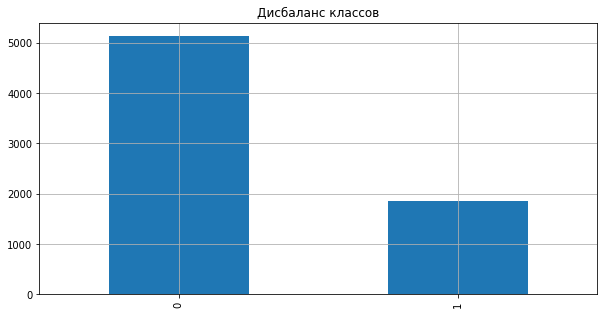

In [70]:
data['Churn'].value_counts().plot(kind='bar',
                                 grid=True,
                                 figsize=(10, 5),
                                 title='Дисбаланс классов');

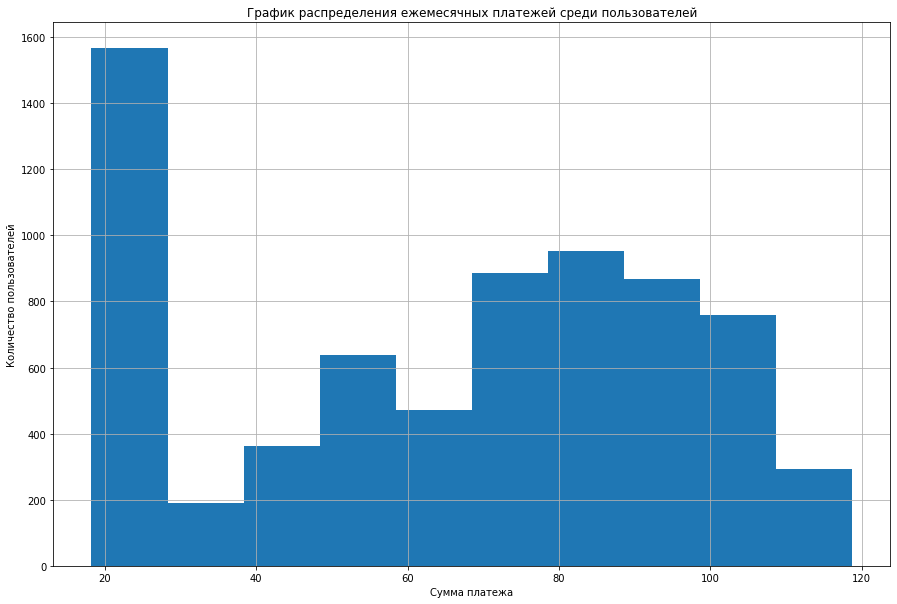

In [71]:
data['MonthlyCharges'].hist(figsize=(15, 10))
plt.title('График распределения ежемесячных платежей среди пользователей')
plt.xlabel('Сумма платежа')
plt.ylabel('Количество пользователей');

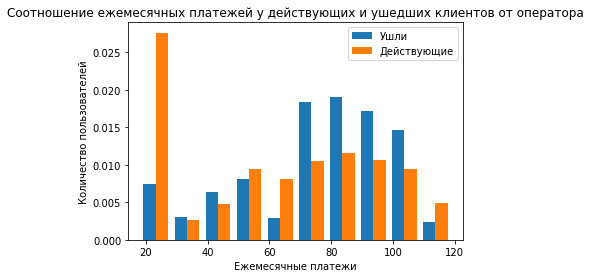

In [72]:
plt.hist([data[data.Churn == 1].MonthlyCharges, data[data.Churn == 0].MonthlyCharges], 
         label=['Ушли', 'Действующие'], density=True);
plt.legend();
plt.title('Соотношение ежемесячных платежей у действующих и ушедших клиентов от оператора')
plt.xlabel('Ежемесячные платежи')
plt.ylabel('Количество пользователей');
plt.show();

##### **3. Подготовка данных к обучению.**

In [73]:
target = data['Churn']
features = data.drop('Churn', axis=1)

In [74]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

In [75]:
print(features_train.shape)
print(target_train.shape)


(5245, 13)
(5245,)


In [76]:
print(features_test.shape)
print(target_test.shape)

(1749, 13)
(1749,)


In [77]:
features_train.head(5)

,Type,MonthlyCharges,Period,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,
7733-UDMTP,Month-to-month,55.00,1737,No,No,DSL,No,Yes,Yes,No,Yes,Yes,No
7721-JXEAW,Month-to-month,41.05,1796,Yes,No,DSL,No,Yes,No,No,No,Yes,No
0137-UDEUO,Month-to-month,19.85,92,No,No,No,No,No,No,No,No,No,No
0869-PAPRP,Month-to-month,85.70,792,Yes,No,Fiber optic,No,No,Yes,No,Yes,No,No
5940-NFXKV,Month-to-month,83.65,579,Yes,Yes,Fiber optic,No,No,No,No,No,Yes,Yes


In [78]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
forest_columns = ['Type', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
               'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
encoder.fit(features_train[forest_columns])

features_train_ord = features_train.copy()
features_test_ord = features_test.copy()

features_train_ord[forest_columns] = encoder.transform(features_train_ord[forest_columns])
features_test_ord[forest_columns] = encoder.transform(features_test_ord[forest_columns])

In [79]:
numeric = ['MonthlyCharges', 'Period']

pd.options.mode.chained_assignment = None
scaler = StandardScaler()
scaler.fit(features_train_ord[numeric])
features_train_ord[numeric] = scaler.transform(features_train_ord[numeric])
features_test_ord[numeric] = scaler.transform(features_test_ord[numeric])

In [80]:
features_train_ord.head(5)

,Type,MonthlyCharges,Period,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,
7733-UDMTP,0.0,-0.326225,1.005521,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
7721-JXEAW,0.0,-0.791805,1.084669,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
0137-UDEUO,0.0,-1.499353,-1.201226,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0869-PAPRP,0.0,0.698385,-0.262184,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5940-NFXKV,0.0,0.629966,-0.547921,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [81]:
onehotencoder = OneHotEncoder()
line_columns = ['Type', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
               'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
onehotencoder.fit_transform(features_train[line_columns])
features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()
features_train_ohe[line_columns] = encoder.transform(features_train_ohe[line_columns])
features_test_ohe[line_columns] = encoder.transform(features_test_ohe[line_columns])

In [82]:
features_train_ohe.head(5)

,Type,MonthlyCharges,Period,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,
7733-UDMTP,0.0,55.00,1737,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
7721-JXEAW,0.0,41.05,1796,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
0137-UDEUO,0.0,19.85,92,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0869-PAPRP,0.0,85.70,792,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5940-NFXKV,0.0,83.65,579,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [83]:
numeric = ['MonthlyCharges', 'Period']

pd.options.mode.chained_assignment = None
scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])

##### **4. Обучение**

##### **LogisticRegression**

In [84]:
%%time

model_lr = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', class_weight='balanced')
paramets = {'max_iter': range(100, 200, 300)}
grid_lr = GridSearchCV(model_lr, paramets, scoring='roc_auc', cv=5)                           
grid_lr.fit(features_train_ohe, target_train)
grid_lr.best_score_


CPU times: user 277 ms, sys: 313 ms, total: 590 ms
Wall time: 481 ms


0.8344003105067245

##### **RandomForestClassifier**

In [85]:
%%time

forest_model = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')

forest_param = { 'n_estimators': range(100, 150, 500),
                     'max_depth': range(5, 7, 12),
                     'min_samples_leaf': range(1, 3, 7),
                     'min_samples_split': range(2, 4, 10)}

# GridSearchCV с кросс-валидацией

forest_grid = GridSearchCV(forest_model, forest_param, scoring='roc_auc', cv=5)
forest_grid.fit(features_train_ord, target_train)
forest_grid.best_score_


CPU times: user 1.33 s, sys: 11 ms, total: 1.34 s
Wall time: 1.34 s


0.8504564074746076

##### **CatBoostClassifier**

In [86]:
%%time


cat = CatBoostClassifier(random_state=RANDOM_STATE)
cat_param = {'iterations': [100, 200, 300],
                'learning_rate': [0.03, 0.1],
                'depth': [5, 7, 10]}
cat_grid = GridSearchCV(cat, cat_param, scoring='roc_auc', cv=5)
cat_grid.fit(features_train_ord, target_train, verbose=False)

cat_grid.best_score_


CPU times: user 1min 20s, sys: 1.68 s, total: 1min 21s
Wall time: 2min 40s


0.9168188024915359

In [87]:
# таблица результатов обучения моделей

analis = {'Model' : ['LogisticRegression', 'RandomForestClassifier', 'CatBoostClassifier'],
    'roc_auc_train' :pd.Series([0.834, 0.850, 0.917]),    
    'Time.fit (ms)': pd.Series([481, 94, 9600])}
print(pd.DataFrame(analis))

                    Model  roc_auc_train  Time.fit (ms)
0      LogisticRegression          0.834            481
1  RandomForestClassifier          0.850             94
2      CatBoostClassifier          0.917           9600


##### **5. Тестирование**

In [88]:
%%time

# проверка модели CatBoostClassifier на тестовой выборке

cat = CatBoostClassifier(random_state=RANDOM_STATE)
cat.fit(features_train_ord, target_train, verbose=False)
pred_cat = cat.predict_proba(features_test_ord)[:, 1]
roc_auc = roc_auc_score(target_test, pred_cat)
fpr_test, tpr_test, thresholds = roc_curve(target_test, pred_cat)

print(roc_auc)

0.908514780607415
CPU times: user 1.83 s, sys: 101 ms, total: 1.93 s
Wall time: 2.95 s


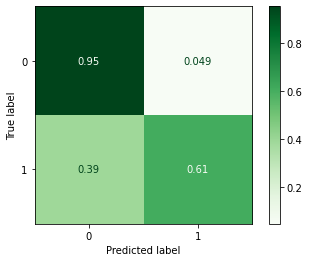

In [90]:
plot_confusion_matrix(estimator=cat, X=features_test_ord, y_true=target_test,
                      normalize='true', cmap='Greens');

<Figure size 432x288 with 0 Axes>

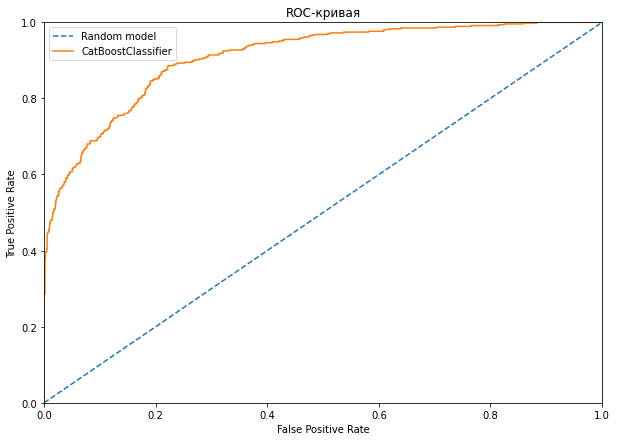

In [91]:
fpr_test, tpr_test, thresholds = roc_curve(target_test, pred_cat)
plt.figure()

plt.figure(figsize=(10, 7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.plot(fpr_test, tpr_test)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('Random model', 'CatBoostClassifier'),
           loc='upper left') 
plt.show();


In [92]:
data = Pool(features_train_ord, target_train)
features = cat.get_feature_importance(data, prettified = True)
print(features)

          Feature Id  Importances
0             Period    58.503231
1     MonthlyCharges    12.676753
2               Type    10.922291
3    InternetService     5.565824
4      MultipleLines     2.371553
5        StreamingTV     1.594644
6        TechSupport     1.508727
7    StreamingMovies     1.449493
8     OnlineSecurity     1.400081
9         Dependents     1.245814
10      OnlineBackup     1.077902
11           Partner     0.981518
12  DeviceProtection     0.702169


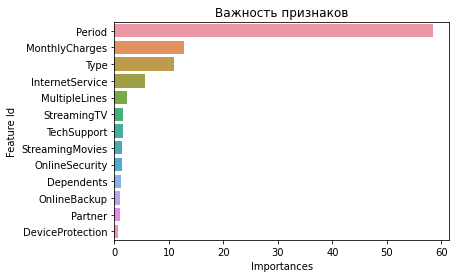

In [93]:
sns.barplot(y=features['Feature Id'], x=features['Importances']);
plt.title('Важность признаков')

plt.show();

In [94]:
# таблица результатов обучения моделей

analis = {'Model' : ['LogisticRegression', 'RandomForestClassifier', 'CatBoostClassifier'],
    'roc_auc_train' :pd.Series([0.834, 0.850, 0.917]),    
    'Time.fit (ms)': pd.Series([481, 94, 9600])}
print(pd.DataFrame(analis))

                    Model  roc_auc_train  Time.fit (ms)
0      LogisticRegression          0.834            481
1  RandomForestClassifier          0.850             94
2      CatBoostClassifier          0.917           9600


In [97]:
# гиперпараметры лучшей модели CatBoostClassifier

best_parametr = cat_grid.best_params_
print(best_parametr)

{'depth': 5, 'iterations': 300, 'learning_rate': 0.1}
